# Test 4

This is the fourth experimental test.

To be done on 8/8/2025

There were some seams in large prints for test 3. So:

- Going to test the alignment by printing a circle in a square

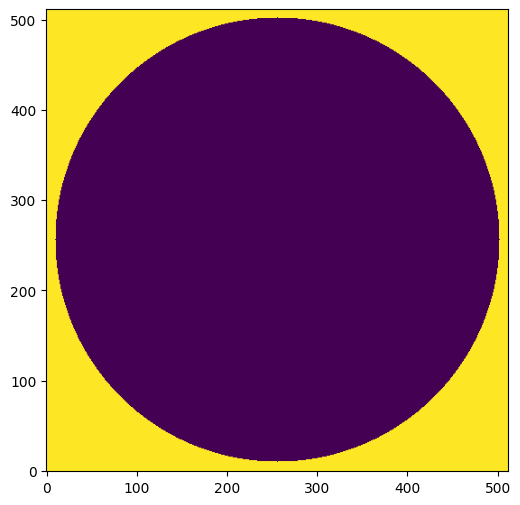

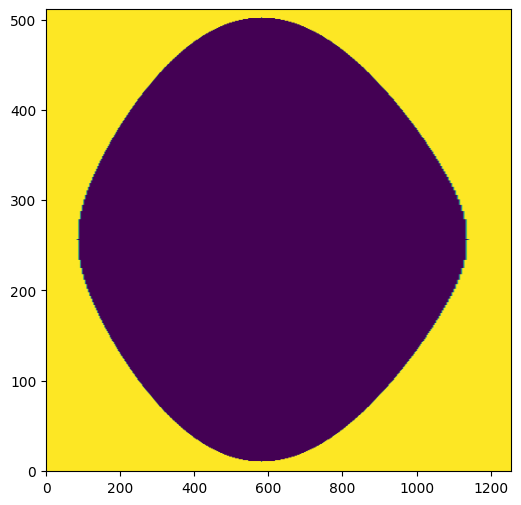

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../../nanostride')
import SPiiPlusPython as sp
import pipython
from pipython import GCSDevice

# Create the square with a centered black circle
height, width = 512, 512
pattern = np.ones((height, width))
center_x, center_y = width // 2, height // 2
radius = min(center_x, center_y) - 10
Y, X = np.ogrid[:height, :width]
mask = (X - center_x)**2 + (Y - center_y)**2 <= radius**2
pattern[mask] = 0

# Prepare interpolation parameters
sampling_rate = 20_000_000
line_duration_us = 157
samples_per_line = sampling_rate * line_duration_us // 2_500_000
original_indices = np.linspace(0, 1, width)

def generate_nonuniform_indices(n_samples):
    lin = np.linspace(0, 1, n_samples)
    return 0.5 - 0.5 * np.cos(np.pi * lin**0.9)

target_indices = generate_nonuniform_indices(samples_per_line)

# Interpolate each row
waveform_rows = [
    np.interp(target_indices, original_indices, row).astype(np.float64)
    for row in pattern
]

# Plot before interpolation
plt.figure(figsize=(6, 6))
plt.imshow(pattern, origin='lower')

# Plot after interpolation
plt.figure(figsize=(6, 6))
plt.imshow(waveform_rows, aspect='auto', origin='lower')

plt.show()


Motion initialize

In [28]:
pidevice = pipython.GCS2Device("C-887")
pidevice.ConnectRS232(5, 115200)
axes = ['X', 'Y', 'Z', 'U', 'V', 'W']
hc = sp.OpenCommSerial(1, 115200)
sp.DisableAll(hc)
sp.EnableM(hc, [0, 1, -1], sp.SYNCHRONOUS, True)

Test using ExtToPointM and setting end velocity to the same as moving velocity

In [29]:
import nifgen
import time

def set_zero():
    session.output_mode = nifgen.OutputMode.FUNC
    session.configure_standard_waveform(waveform=nifgen.Waveform.DC, amplitude=0, frequency=1, dc_offset=0, start_phase=0.0)
    with session.initiate():
        time.sleep(0.1)

def set_normal():
    session.output_mode = nifgen.OutputMode.SEQ
    session.arb_sample_rate = 20_000_000
    session.configure_arb_sequence(sequence_handle, (5.15/2.2), 0)
    session.start_trigger_type = nifgen.StartTriggerType.DIGITAL_EDGE
    session.digital_edge_start_trigger_source = "/Dev1/PFI1"
    session.digital_edge_start_trigger_edge = nifgen.StartTriggerDigitalEdgeEdge.RISING
    session.trigger_mode = nifgen.TriggerMode.STEPPED
    
stage_x = sp.GetTargetPosition(hc, 0, sp.SYNCHRONOUS)
stage_y = sp.GetTargetPosition(hc, 1, sp.SYNCHRONOUS)

axes = [0,1,-1]

with nifgen.Session("Dev1") as session:

    # Set up AWG
    session.output_mode = nifgen.OutputMode.SEQ
    session.arb_sample_rate = 20_000_000

    # Create data structures
    waveform_handle_array = []
    loop_counts = []
    for row in waveform_rows:
        waveform_handle_array.append(session._create_waveform_f64_numpy(row))
        loop_counts.append(1)
    sequence_handle = session.create_arb_sequence(waveform_handle_array, loop_counts)
    session.configure_arb_sequence(sequence_handle, (5.15/2.2), 0)

    # Set up triggers
    session.start_trigger_type = nifgen.StartTriggerType.DIGITAL_EDGE
    session.digital_edge_start_trigger_source = "/Dev1/PFI1"
    session.digital_edge_start_trigger_edge = nifgen.StartTriggerDigitalEdgeEdge.RISING
    session.trigger_mode = nifgen.TriggerMode.STEPPED

    # Get starting position for hexapod
    hexapod_axes = ['X', 'Y', 'Z', 'U', 'V', 'W']
    hexapod_positions = pidevice.qPOS(hexapod_axes)
    hexapod_z = hexapod_positions['Z']

    # Print parameters
    layers = 250
    y_lims = 1.0
    z_steps = 0.001

    # Initiate -> Move Stage -> Abort -> Move Hexapod -> Initiate
    for i in range(layers):
        set_normal()
        #session.output_enabled = True
        session.initiate()
        print(f"Starting layer {i+1}")
        sp.ExtToPoint(
        hc,
        sp.MotionFlags.ACSC_AMF_VELOCITY | sp.MotionFlags.ACSC_AMF_ENDVELOCITY,
        sp.Axis.ACSC_AXIS_1,
        stage_y+y_lims,
        15.82,
        15.82,
        wait=sp.SYNCHRONOUS,
        failure_check=True
        )
        sp.WaitLogicalMotionEnd(hc, sp.Axis.ACSC_AXIS_1, timeout=-1)
        #session.output_enabled = False
        session.abort()
        set_zero()
        print(f"Moving down")
        pidevice.MOV('Z', (hexapod_z - ((i+1)*z_steps)))
        #pidevice.MOV('Z', y_lims)
        while pidevice.IsMoving()['Z']:
            time.sleep(0.01)
        y_lims *= -1
    
    set_zero()

sp.EndSequenceM(hc, axes) # end of multipoint motion
pidevice.CloseConnection()
sp.DisableAll(hc)
sp.CloseComm(hc)

Starting layer 1
Moving down
Starting layer 2
Moving down
Starting layer 3
Moving down
Starting layer 4
Moving down
Starting layer 5
Moving down
Starting layer 6
Moving down
Starting layer 7
Moving down
Starting layer 8
Moving down
Starting layer 9
Moving down
Starting layer 10
Moving down
Starting layer 11
Moving down
Starting layer 12
Moving down
Starting layer 13
Moving down
Starting layer 14
Moving down
Starting layer 15
Moving down
Starting layer 16
Moving down
Starting layer 17
Moving down
Starting layer 18
Moving down
Starting layer 19
Moving down
Starting layer 20
Moving down
Starting layer 21
Moving down
Starting layer 22
Moving down
Starting layer 23
Moving down
Starting layer 24
Moving down
Starting layer 25
Moving down
Starting layer 26
Moving down
Starting layer 27
Moving down
Starting layer 28
Moving down
Starting layer 29
Moving down
Starting layer 30
Moving down
Starting layer 31
Moving down
Starting layer 32
Moving down
Starting layer 33
Moving down
Starting layer 34
M